In [15]:
# Necessary imports
%load_ext autoreload
%autoreload 2

import networkx as nx
import numpy as np
import pandas as pd
import scipy.sparse as sps
import pickle


from openTCGA.multiomics import MultiOmicsData
from moge.visualization.plot_data import matrix_heatmap, plot_coo_matrix
from moge.visualization.visualize_embedding import visualize_embedding, plot_bokeh_graph

import seaborn
import matplotlib.pyplot as plt
from moge.network.omics_distance import *


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Import the TCGA cancer data

In [2]:
# import pickle
# with open('moge/data/luad_data_multi_U-T.pickle', 'wb') as file:
# #     luad_data = pickle.load(file)
#     pickle.dump(luad_data, file)

In [3]:
folder_path = "/data/datasets/Bioinformatics_ExternalData/tcga-assembler/LUAD/"
external_data_path = "/data/datasets/Bioinformatics_ExternalData/"
luad_data = MultiOmicsData(cancer_type="LUAD", tcga_data_path=folder_path, external_data_path=external_data_path,
                           import_sequences="shortest", replace_U2T=True,
                           modalities=[\
                                       "GE",
                                       "MIR",
                                       "LNC",
                                       # "CNV",
                                       # "SNP",
#                                        "PRO",
                                       # "DNA"
                                       ])

/opt/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3781: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)


Unmatched lncRNAs 12727
Unmatched lncRNAs after gencode: 1033
Unmatched lncRNAs after lncBase: 812
Unmatched lncRNAs after HGNC: 758
Unmatched lncRNAs after lncipedia: 622
PATIENTS (522, 110)
DRUGS (461, 4)
GE (576, 20157)
MIR (494, 1870)
LNC (546, 12727)
SAMPLES (599, 111)
Processed genes info for  GE
Processed genes info for  MIR
Processed genes info for  LNC


In [4]:
LNC = luad_data.LNC.get_genes_info()
MIR = luad_data.MIR.get_genes_info()
GE = luad_data.GE.get_genes_info()
print(GE.columns)
print(MIR.columns)
print(LNC.columns)

Index(['Transcript ID', 'Gene ID', 'Gene description', '3P-seq tags',
       'locus_type', 'location', 'gene_family', 'gene_family_id',
       'Transcript sequence', 'GO Terms', 'Disease association', 'Chromosome',
       'Chromosome arm', 'Chromosome region', 'Chromosome band',
       'Transcript length', 'Family'],
      dtype='object')
Index(['miR family', 'Seed+m8', 'Mature sequence', 'Family Conservation?',
       'MiRBase Accession', 'MiRBase ID', 'location', 'ensembl_gene_id',
       'Disease association', 'locus_type', 'Transcript sequence',
       'Transcript length', 'Chromosome', 'Chromosome arm',
       'Chromosome region', 'Chromosome band', 'GO Terms', 'Rfams', 'Family'],
      dtype='object')
Index(['Gene ID', 'Gene Name', 'HGNC Gene Name', 'Transcript id',
       'Transcript name', 'Transcript type', 'tag', 'Chromosome', 'start',
       'end', 'Strand', 'locus_type', 'Transcript sequence',
       'Disease association', 'GO Terms', 'Rfams', 'Family'],
      dtype='object

In [5]:
gene_exp_medians = pd.read_csv("/data/datasets/Bioinformatics_ExternalData/GTEx/GTEx_Analysis_2016-01-15_v7_RNASeQCv1.1.8_gene_median_tpm.gct", sep='\t', header=1, skiprows=1)
gene_exp_medians.index = gene_exp_medians["Description"]
gene_exp_medians.drop("gene_id", axis=1, inplace=True)
gene_exp_medians.drop("Description", axis=1, inplace=True)
gene_exp_medians.index.rename("gene_id", inplace=True)

In [6]:
transcript_exp_medians = pd.read_csv("/data/datasets/Bioinformatics_ExternalData/GTEx/GTEx_Analysis_2016-01-15_v7_RSEMv1.2.22_transcript_median_tpm.tsv", sep='\t')
transcript_exp_medians.index = transcript_exp_medians["gene_id"]
transcript_exp_medians.drop("gene_id", axis=1, inplace=True)
# transcript_exp_medians = transcript_exp_medians.T
transcript_exp_medians.index = transcript_exp_medians.index.str.replace("[.].*", "")

In [7]:
mir_gene_id_to_name = pd.Series(MIR["MiRBase ID"].values, index=MIR["ensembl_gene_id"]).to_dict()
lnc_gene_id_to_name = pd.Series(LNC.index.values, index=LNC["Gene ID"]).to_dict()

In [8]:
GE_tissue_exp = gene_exp_medians[gene_exp_medians.index.isin(GE.index)]
GE_tissue_exp = GE_tissue_exp[~GE_tissue_exp.index.duplicated(keep="first")]
GE_tissue_exp.shape

(18653, 53)

In [9]:
LNC_tissue_exp = transcript_exp_medians[transcript_exp_medians.index.isin(lnc_gene_id_to_name.keys())]
LNC_tissue_exp.index = LNC_tissue_exp.index.map(lnc_gene_id_to_name)
LNC_tissue_exp.shape

(12706, 53)

In [10]:
MIR_tissue_exp = transcript_exp_medians[transcript_exp_medians.index.isin(mir_gene_id_to_name.keys())]
MIR_tissue_exp["gene_id"] = MIR_tissue_exp.index
MIR_tissue_exp["gene_id"].replace(mir_gene_id_to_name, inplace=True)
MIR_tissue_exp.index = MIR_tissue_exp["gene_id"]
MIR_tissue_exp.drop("gene_id", axis=1, inplace=True)
MIR_tissue_exp.shape

/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/opt/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:5890: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)
/opt/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


(1181, 53)

# Test nodes affinities features

In [20]:
# node_list = GE[GE["gene_family"].notnull()].index[0:1000]
node_list = GE.index
# correlation_dist = compute_expression_correlation_dists(luad_data, modalities=["GE"],
#                                                         node_list=node_list, absolute_corr=True,
#                                                         squareform=False)
affinity = compute_annotation_affinities(GE, node_list=node_list,
                features=["location"], 
#                features=["Family", "tag", "Strand", "Chromosome"], 
#                                          correlation_dist=correlation_dist,
                                        nanmean=False, 
#                                          weights=[1, 1, 0.5, 0.5, 5],
                                        )


Gower's dissimilarity: Computing location , dtype: object , shape: (20157,)
['19q13.43', '10q11.23', '12p13.31', '12p13.31', '22q13.2']
Location split to Chromosome, arm, region
Gower's dissimilarity: Computing Chromosome , dtype: object , shape: (20157,)
['19', '10', '12', '12', '22']
Dice distance


/opt/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype uint8 was converted to bool by check_pairwise_arrays.
  warnings.warn(msg, DataConversionWarning)


Gower's dissimilarity: Computing arm , dtype: object , shape: (20157,)
['q', 'q', 'p', 'p', 'q']
Dice distance


/opt/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype uint8 was converted to bool by check_pairwise_arrays.
  warnings.warn(msg, DataConversionWarning)


Gower's dissimilarity: Computing region , dtype: object , shape: (20157,)
['13', '11', '13', '13', '13']
Dice distance


/opt/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype uint8 was converted to bool by check_pairwise_arrays.
  warnings.warn(msg, DataConversionWarning)


Gower's dissimilarity: Computing band , dtype: object , shape: (20157,)
['43', '23', '31', '31', '2']
Dice distance


/opt/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype uint8 was converted to bool by check_pairwise_arrays.
  warnings.warn(msg, DataConversionWarning)
/home/jonny/PycharmProjects/MultiOmicsGraphEmbedding/moge/network/omics_distance.py:166: RuntimeWarning: invalid value encountered in greater_equal
  
/home/jonny/PycharmProjects/MultiOmicsGraphEmbedding/moge/network/omics_distance.py:168: RuntimeWarning: Mean of empty slice
  


(203142246,)


/home/jonny/PycharmProjects/MultiOmicsGraphEmbedding/moge/evaluation/utils.py:17: RuntimeWarning: divide by zero encountered in log10
  c = np.log10(np.power(degrees, k_power))
/home/jonny/PycharmProjects/MultiOmicsGraphEmbedding/moge/evaluation/utils.py:18: RuntimeWarning: divide by zero encountered in log10
  d = np.log10(cosine_adj_hist_dist.pdf(np.power(degrees, k_power)))


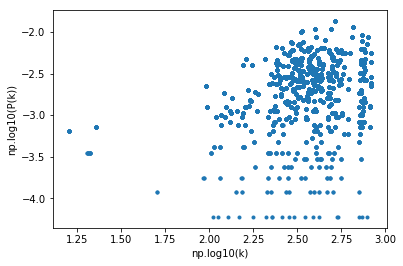

0.05761450686541157

In [34]:
from moge.evaluation.utils import get_scalefree_fit_score
from scipy.sparse import triu
from scipy.spatial.distance import squareform

affinities = squareform(affinity, checks=False)
print(affinities.shape)
adj_list = np.nansum(affinity, axis=1)
# adj_list = affinities[np.where(~np.isnan(affinities.data))].reshape((-1))

get_scalefree_fit_score(adj_list, plot=True)

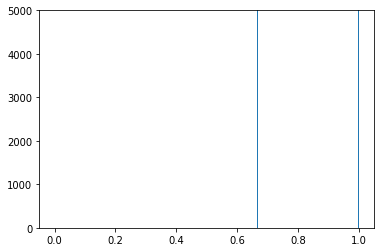

In [35]:
plt.hist(affinity[np.where(~np.isnan(affinity))].reshape((-1)), bins=500)
plt.ylim(top=5000)
plt.show()

In [23]:
threshold=0.70
print("threshold at", threshold,":",(affinity > threshold).sum())
# print("threshold at", threshold,":",(affinity < 0.01).sum())

/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in greater
  


threshold at 0.7 : 2735238


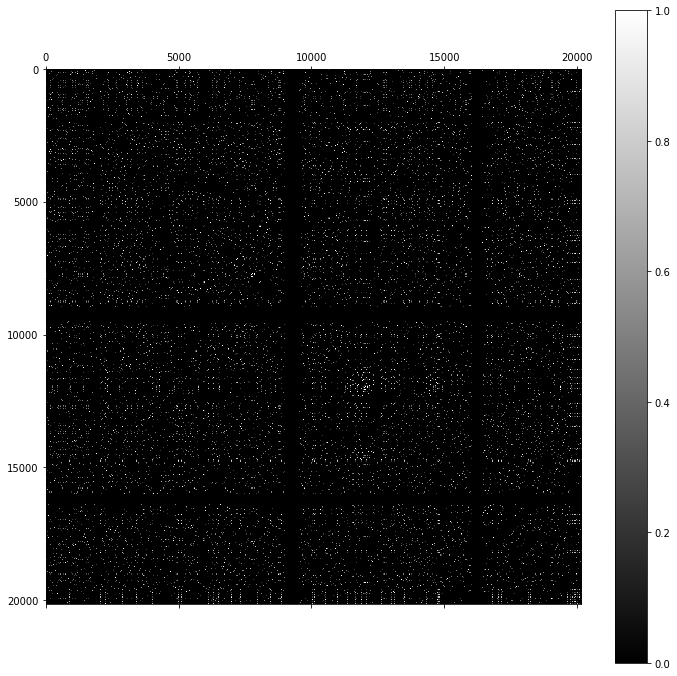

In [30]:
# matrix_heatmap(np.array(affinity>threshold, dtype=float))
matrix_heatmap(affinity)

/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in less
  """Entry point for launching an IPython kernel.


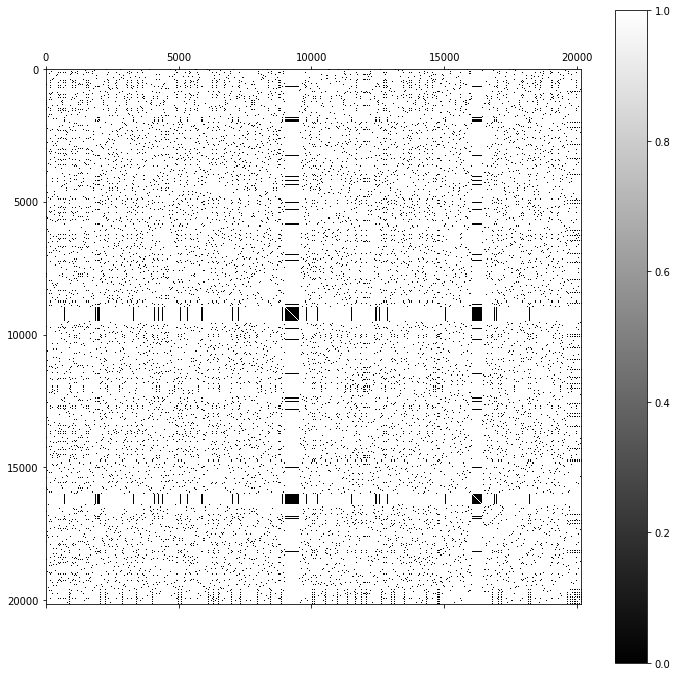

In [25]:
matrix_heatmap(np.array(affinity<0.01, dtype=float))

# Heterogeneous Network

In [2]:
import pickle
with open('moge/data/luad_data_shortest.pickle', 'rb') as file:
    luad_data = pickle.load(file)
#     pickle.dump(luad_data, file)

In [3]:
from moge.network.heterogeneous_network import HeterogeneousNetwork

network = HeterogeneousNetwork(modalities=["MIR", "GE", "LNC"], multi_omics_data=luad_data)

MIR  nodes: 1870
GE  nodes: 20157
LNC  nodes: 12706
Total nodes: 34732
Genes info columns: ['Disease association', 'locus_type', 'Transcript sequence', 'Chromosome', 'GO Terms', 'Family']


## Write node labels to file

In [4]:
from moge.network.file_io import write_node_labels_to_file

# write_node_labels_to_file("moge/data/lncRNA_miRNA_mRNA/lncRNA-miRNA-mRNA_node_labels_family.tsv", luad_data, 
#                           label_cols=["family"],
#                           modalities=["MIR", "GE", "LNC"], 
#                           get_dummies=False)

# write_node_labels_to_file("moge/data/lncRNA_miRNA_mRNA/lncRNA-miRNA-mRNA_node_labels_disease_dummies.tsv", luad_data, 
#                           label_cols=["Disease association"],
#                           modalities=["MIR", "GE", "LNC"], remove_na=True, sep="\t",
#                           get_dummies=True)

# Add Attribute Affinity Positive Edges

In [18]:
affinities_GE = network.add_edges_from_nodes_similarity(modality="GE", node_list=network.nodes["GE"], 
    similarity_threshold=0.70, dissimilarity_threshold=0.01,
    negative_sampling_ratio=5.0, nanmean=True,
    features=["GO Terms", "Disease association"],
    weights=[1, 1, 1],
    compute_correlation=True, tissue_expression=GE_tissue_exp)

Gower's dissimilarity: Computing GO Terms , dtype: object , shape: (20157,)
Dice distance
Gower's dissimilarity: Computing Disease association , dtype: object , shape: (20157,)
Dice distance
Correlation distance (203142246,)


/home/jonny/PycharmProjects/MultiOmicsGraphEmbedding/moge/network/omics_distance.py:72: RuntimeWarning: Mean of empty slice
  agg_func = lambda x: np.nanmean(x, axis=0)


94763 undirected positive edges (type='u') added.
473815 undirected negative edges (type='u_n') added.


In [19]:
affinities_GE = network.add_edges_from_nodes_similarity(modality="GE", node_list=network.nodes["GE"], 
    similarity_threshold=0.85, dissimilarity_threshold=0.01,
    negative_sampling_ratio=5.0, nanmean=False,
    features=["locus_type", "gene_family_id", "location"], 
    weights=[0.5, 1, 0.5, 1],
    compute_correlation=True, tissue_expression=GE_tissue_exp)

Gower's dissimilarity: Computing locus_type , dtype: object , shape: (20157,)
Dice distance
Gower's dissimilarity: Computing gene_family_id , dtype: object , shape: (20157,)
Dice distance
Gower's dissimilarity: Computing location , dtype: object , shape: (20157,)
Location split to Chromosome, arm, region
Gower's dissimilarity: Computing Chromosome , dtype: object , shape: (20157,)
Dice distance
Gower's dissimilarity: Computing arm , dtype: object , shape: (20157,)
Dice distance
Gower's dissimilarity: Computing region , dtype: object , shape: (20157,)
Dice distance
Gower's dissimilarity: Computing band , dtype: object , shape: (20157,)
Dice distance


/home/jonny/PycharmProjects/MultiOmicsGraphEmbedding/moge/network/omics_distance.py:183: RuntimeWarning: invalid value encountered in greater_equal
  """
/home/jonny/PycharmProjects/MultiOmicsGraphEmbedding/moge/network/omics_distance.py:185: RuntimeWarning: Mean of empty slice
  X[i][np.where(X[i-1] >= X[i])] = X[i-1][np.where(X[i-1] >= X[i])] # the distance of child feature is only as great as distance of parent features


23598 undirected positive edges (type='u') added.
117990 undirected negative edges (type='u_n') added.


In [20]:
affinities_MIR = network.add_edges_from_nodes_similarity(modality="MIR", node_list=network.nodes["MIR"], 
    similarity_threshold=0.70, dissimilarity_threshold=0.01,
    negative_sampling_ratio=5.0, nanmean=True,
    features=["GO Terms", "Disease association"], 
    compute_correlation=False)

Gower's dissimilarity: Computing GO Terms , dtype: object , shape: (1870,)
Dice distance
Gower's dissimilarity: Computing Disease association , dtype: object , shape: (1870,)
Dice distance
701 undirected positive edges (type='u') added.
3505 undirected negative edges (type='u_n') added.


/home/jonny/PycharmProjects/MultiOmicsGraphEmbedding/moge/network/omics_distance.py:72: RuntimeWarning: Mean of empty slice
  agg_func = lambda x: np.nanmean(x, axis=0)


In [21]:
affinities_MIR = network.add_edges_from_nodes_similarity(modality="MIR", node_list=network.nodes["MIR"], 
    similarity_threshold=0.70, dissimilarity_threshold=0.01,
    negative_sampling_ratio=5.0, nanmean=True,
    features=["Family", "Rfams"], 
    compute_correlation=False)

Gower's dissimilarity: Computing Family , dtype: object , shape: (1870,)
Dice distance
Gower's dissimilarity: Computing Rfams , dtype: object , shape: (1870,)
Dice distance
683 undirected positive edges (type='u') added.
3415 undirected negative edges (type='u_n') added.


/home/jonny/PycharmProjects/MultiOmicsGraphEmbedding/moge/network/omics_distance.py:72: RuntimeWarning: Mean of empty slice
  agg_func = lambda x: np.nanmean(x, axis=0)


In [22]:
affinities_LNC = network.add_edges_from_nodes_similarity(modality="LNC", node_list=network.nodes["LNC"], 
    similarity_threshold=0.90, dissimilarity_threshold=0.1,
    negative_sampling_ratio=5.0, 
    nanmean=False,
    features=["locus_type", "Transcript type", "tag", "Strand", "Chromosome"],
    weights=[1, 1, 0.5, 0.5, 1, 3],
    compute_correlation=True, tissue_expression=LNC_tissue_exp)

Gower's dissimilarity: Computing locus_type , dtype: object , shape: (12706,)
Dice distance
Gower's dissimilarity: Computing Transcript type , dtype: object , shape: (12706,)
Dice distance
Gower's dissimilarity: Computing tag , dtype: object , shape: (12706,)
Dice distance
Gower's dissimilarity: Computing Strand , dtype: object , shape: (12706,)
Dice distance
Gower's dissimilarity: Computing Chromosome , dtype: object , shape: (12706,)
Dice distance
Correlation distance (80714865,)
117821 undirected positive edges (type='u') added.
589105 undirected negative edges (type='u_n') added.


In [23]:
affinities_LNC = network.add_edges_from_nodes_similarity(modality="LNC", node_list=network.nodes["LNC"], 
    similarity_threshold=0.70, dissimilarity_threshold=0.01,
    negative_sampling_ratio=5.0, nanmean=True,
    features=["GO Terms", "Family", "Disease association"], 
    compute_correlation=False)

Gower's dissimilarity: Computing GO Terms , dtype: object , shape: (12706,)
Dice distance
Gower's dissimilarity: Computing Family , dtype: object , shape: (12706,)
Dice distance
Gower's dissimilarity: Computing Disease association , dtype: object , shape: (12706,)
Dice distance


/home/jonny/PycharmProjects/MultiOmicsGraphEmbedding/moge/network/omics_distance.py:72: RuntimeWarning: Mean of empty slice
  agg_func = lambda x: np.nanmean(x, axis=0)


463 undirected positive edges (type='u') added.
2315 undirected negative edges (type='u_n') added.


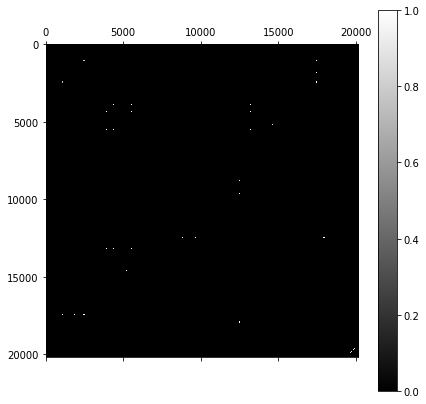

In [24]:
matrix_heatmap(network.get_adjacency_matrix(edge_types=["u"], node_list=network.nodes["GE"]).todense(),
              figsize=(7,7))

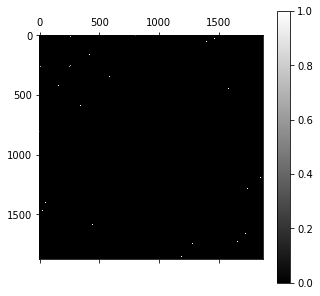

In [25]:
matrix_heatmap(network.get_adjacency_matrix(edge_types=["u"], node_list=network.nodes["MIR"]).todense(),
              figsize=(5,5))

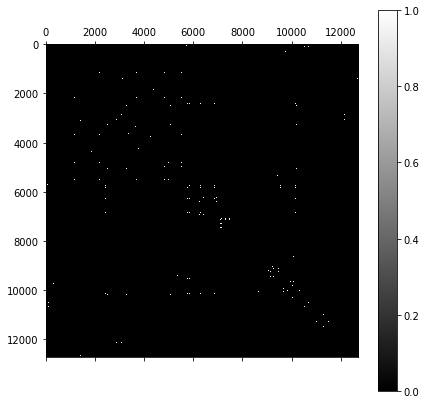

In [26]:
matrix_heatmap(network.get_adjacency_matrix(edge_types=["u"], node_list=network.nodes["LNC"]).todense(),
              figsize=(7,7))

In [59]:
# IMPORT Affinity Edgelist
network.import_edgelist_file(
#     file="moge/data/LMN_only_directed/affinity/lmn_n70_m70_l70-70_TissueExp_GO_Rfams_Disease_Family_GO_affinity.edgelist", 
    file="moge/data/LMN_future_recall/TRAIN/Interactions_Affinity/lmn_n70_m70_l70-70_GO_Rfams_Disease_Family_GO_affinity.edgelist", 
    is_directed=False)

In [32]:
# # WRITE Affinity Edgelist
# nx.write_edgelist(network.get_subgraph(["MIR", "GE", "LNC"], edge_type="u"), 
#                   "moge/data/LMN_future_recall/TRAIN/Interactions_Affinity/lmn_n70_m70_l70-70_TissueExp_GO_Rfams_Disease_Family_GO_affinity.edgelist", 
#                   data=True)

# Add Attribute Affinity NEGATIVE Edges between cross-modals

In [11]:
u_n_size = 10000
network.add_sampled_negative_edges(u_n_size, modalities=["GE", "MIR"])
network.add_sampled_negative_edges(u_n_size*2, modalities=["GE", "LNC"])
network.add_sampled_negative_edges(u_n_size, modalities=["LNC", "MIR"])

Number of negative sampled edges between ['GE', 'MIR'] added: 10000
Number of negative sampled edges between ['GE', 'LNC'] added: 20000
Number of negative sampled edges between ['LNC', 'MIR'] added: 10000


# miRTarBase

In [85]:
mirtarbase_new = luad_data.MIR.get_miRTarBase_miRNA_target_interaction(use_latest=True, data=False, rename_dict=case_relabel)
mirtarbase_old = luad_data.MIR.get_miRTarBase_miRNA_target_interaction(use_latest=False, data=False, rename_dict=case_relabel)
mirtarbase_diff = list(set(mirtarbase_new) - set(mirtarbase_old))
len(mirtarbase_diff)

64449

In [86]:
# Adds miRNA-target interaction network
network.add_directed_edges_from_edgelist(edgelist=mirtarbase_diff, #luad_data.MIR.get_miRTarBase_miRNA_target_interaction(use_latest=True,
#                                                                                                        rename_dict=case_relabel), 
                                        modalities=["MIR", "GE"], correlation_weights=False, threshold=0.20,
                                        database="miRTarBase")

Adding edgelist with 1746 total unique MIR genes (source), but only matching 1615 nodes
Adding edgelist with 4708 total unique GE genes (target), but only matching 4594 nodes
64449 edges added.


# StarBase mRNA-RNA

In [13]:
starbase_new = luad_data.GE.get_starBase_RNA_RNA_interactions(min_expNum=1, data=False)
starbase_old = luad_data.GE.get_starBase_RNA_RNA_interactions(min_expNum=2, data=False)
starbase_diff = list(set(starbase_new) - set(starbase_old))
len(starbase_diff)

1516287

In [8]:
# Adds Gene Regulatory Network edges
network.add_directed_edges_from_edgelist(edgelist=luad_data.LNC.get_starBase_lncRNA_RNA_interactions(),
                                        modalities=["LNC", "GE"], correlation_weights=False, threshold=0.2,
                                        database="starBase")

Adding edgelist with 359 total unique LNC genes (source), but only matching 295 nodes
Adding edgelist with 10016 total unique GE genes (target), but only matching 6470 nodes
20600 edges added.


/opt/anaconda3/lib/python3.6/site-packages/TCGAMultiOmics/genomic.py:301: FutureWarning: read_table is deprecated, use read_csv instead.
  "pairGeneType", "interactionNum", 'expNum', "FreeEnergy"])


# BioGRID

In [87]:
biogrid_new = luad_data.GE.get_BioGRID_GRN_edgelist(data=False, rename_dict=case_relabel,
                biogrid_interactions_file_path='/data/datasets/Bioinformatics_ExternalData/BioGRID/BIOGRID-ALL-3.5.169.tab2.txt')
biogrid_old = luad_data.GE.get_BioGRID_GRN_edgelist(data=False, rename_dict=case_relabel,
                biogrid_interactions_file_path='/data/datasets/Bioinformatics_ExternalData/BioGRID/BIOGRID-ALL-3.4.162.tab2.txt')
biogrid_diff = list(set(biogrid_new) - set(biogrid_old))
len(biogrid_diff)

/opt/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3214: DtypeWarning: Columns (19,20) have mixed types. Specify dtype option on import or set low_memory=False.
  if (yield from self.run_code(code, result)):


33466

In [88]:
# Adds Gene Regulatory Network edges
network.add_directed_edges_from_edgelist(edgelist=biogrid_diff, #luad_data.GE.get_BioGRID_GRN_edgelist(biogrid_interactions_file_path='/data/datasets/Bioinformatics_ExternalData/BioGRID/BIOGRID-ALL-3.5.169.tab2.txt',
#                                                                                        rename_dict=case_relabel),
                                        modalities=["GE", "GE"], correlation_weights=False, threshold=0.2,
                                        database="BioGRID")

Adding edgelist with 2234 total unique GE genes (source), but only matching 2179 nodes
Adding edgelist with 7618 total unique GE genes (target), but only matching 7293 nodes
33466 edges added.


# NPInter

In [89]:
from moge.network.heterogeneous_network import get_rename_dict
noncode_rename_dict = pd.Series(luad_data.LNC.noncode_func_df["Gene Name"].values,
     index=luad_data.LNC.noncode_func_df["NONCODE Gene ID"].str.split(".", expand=True)[0]).to_dict()
noncode_rename_dict = {k: noncode_rename_dict[k] for k in noncode_rename_dict if type(noncode_rename_dict[k])!=float}

lncbase_rename_dict = get_rename_dict(luad_data.LNC.get_genes_info(), "Gene ID")
lncbase_rename_dict.update(noncode_rename_dict)

In [90]:
lncbase_rename_dict.update(case_relabel)

In [91]:
npinter_new = luad_data.LNC.get_NPInter_ncRNA_RNA_regulatory_interaction_edgelist(use_latest=True, data=False,
                                                                                 rename_dict=lncbase_rename_dict)
npinter_old = luad_data.LNC.get_NPInter_ncRNA_RNA_regulatory_interaction_edgelist(use_latest=False, data=False,
                                                                                 rename_dict=lncbase_rename_dict)
npinter_diff = list(set(npinter_new) - set(npinter_old))
len(npinter_diff)

123054

In [92]:
network.add_directed_edges_from_edgelist(edgelist=npinter_diff, #luad_data.LNC.get_NPInter_ncRNA_RNA_regulatory_interaction_edgelist(use_latest=True, 
#                                                                                                                       rename_dict=lncbase_rename_dict),
                                         modalities=["LNC", "GE"], correlation_weights=False, threshold=0.20,
                                        database="NPInter")

Adding edgelist with 9377 total unique LNC genes (source), but only matching 507 nodes
Adding edgelist with 2726 total unique GE genes (target), but only matching 1465 nodes
123054 edges added.


# lncBase

In [93]:
lncbase_new = luad_data.LNC.get_lncBase_miRNA_lncRNA_predicted_interactions_edgelist(rename_dict=lncbase_rename_dict,
                                                                                     data=False)
lncbase_old = luad_data.LNC.get_lncBase_miRNA_lncRNA_interactions_edgelist(rename_dict=lncbase_rename_dict, 
                                                                           data=False)
lncbase_diff = list(set(lncbase_new) - set(lncbase_old))
print(len(lncbase_diff))

337031


In [94]:
# Adds miRNA-lncRNA interaction network
# network.add_directed_edges_from_edgelist(edgelist=luad_data.LNC.get_starBase_lncRNA_miRNA_interactions_edgelist(),
#                                         )
# network.add_directed_edges_from_edgelist(edgelist=luad_data.LNC.get_lncRNome_miRNA_binding_sites_edgelist(),
#                                          modalities=["LNC", "MIR"], correlation_weights=False, threshold=0.20,
#                                         database="lncRNome")

network.add_directed_edges_from_edgelist(edgelist=lncbase_diff, # luad_data.LNC.get_lncBase_miRNA_lncRNA_interactions_edgelist(rename_dict=lncbase_rename_dict),
                                         modalities=["MIR", "LNC"], correlation_weights=False, threshold=0.20,
                                        database="lncBase")


# network.add_directed_edges_from_edgelist(edgelist=luad_data.LNC.get_LncReg_lncRNA_RNA_regulatory_interactions(),
#                                          modalities=["LNC", "GE"], correlation_weights=False, threshold=0.20,
#                                         database="LncReg")

Adding edgelist with 1746 total unique MIR genes (source), but only matching 1615 nodes
Adding edgelist with 20412 total unique LNC genes (target), but only matching 11692 nodes
337031 edges added.


# lncrna2target

In [95]:
lnc2tar_low = luad_data.LNC.get_lncrna2target_low_throughput_interactions(data=False, rename_dict=lncbase_rename_dict)
lnc2tar_high = luad_data.LNC.get_lncrna2target_high_throughput_interactions(data=False, rename_dict=lncbase_rename_dict)
lnc2tar_diff = list(set(lnc2tar_high) - set(lnc2tar_low))
len(lnc2tar_diff)

65624

In [96]:
network.add_directed_edges_from_edgelist(edgelist=lnc2tar_diff, #luad_data.LNC.get_lncrna2target_high_throughput_interactions(rename_dict=lncbase_rename_dict),
                                         modalities=["LNC", "GE"], correlation_weights=False, threshold=0.20,
                                        database="lncrna2target")

# network.add_directed_edges_from_edgelist(edgelist=luad_data.LNC.get_lncrna2target_low_throughput_interactions(rename_dict=lncbase_rename_dict),
#                                          modalities=["LNC", "GE"], correlation_weights=False, threshold=0.20,
#                                         database="lncrna2target")

# network.add_directed_edges_from_edgelist(edgelist=luad_data.LNC.get_lncRInter_interactions(),
#                                          modalities=["LNC", "GE"], correlation_weights=False, threshold=0.20,
#                                         database="lncRInter")

Adding edgelist with 61 total unique LNC genes (source), but only matching 17 nodes
Adding edgelist with 28865 total unique GE genes (target), but only matching 16554 nodes
65624 edges added.


In [ ]:
npinter_val = {(u,v) for u,v,d in network.G.edges(data=True) if "database" in d and d["database"]=="NPInter"}
len(npinter_val)
npinter_train = {(u,v) for u,v,d in network.G.edges(data=True) if "database" in d and d["database"]=="NPInter"}
len(npinter_train)
len(lncbase_train & l2t_val)

# Filter the edges

In [3]:
with open('moge/data/LMN_future_recall/TRAIN/Interactions_Affinity/LMN_lncbase_mirtarbase_biogrid_npinter_lncrna2target.train_v2.pickle', 
          'rb') as file:
    network = pickle.load(file)

In [36]:
edges_bunch = [(u,v,d) for u,v,d in network.G.edges(data=True) if ("database" in d and 
                                                                   d["database"]=="miRTarBase")]
print(len(edges_bunch))

319246


In [37]:
database_nodes = nx.DiGraph(incoming_graph_data=edges_bunch).nodes()
database_nodes = list(database_nodes)
len(database_nodes)

16695

In [38]:
edges_bunch = [(u,v,d) for u,v,d in network.G.edges(nbunch=database_nodes, data=True) \
               if d["type"] == 'u' or d["type"] == "u_n" or ("database" in d and d["database"]=="miRTarBase")]
print(len(edges_bunch))

664279


In [39]:
network.G.clear()
network.G.add_edges_from(edges_bunch)

# Filter the node_list

In [72]:
node_pairs = {(node1, node2) for node1 in network.G.node for node2 in network.G.node if\
              node1!=node2 and node2.lower()==node1.lower()}
len(node_pairs)

152

In [74]:
# case_relabel = {}
for u,v in node_pairs:
    if v in network.genes_info.index:
        case_relabel[u] = v
    elif u in network.genes_info.index:
        case_relabel[v] = u
len(case_relabel)

2818

In [105]:
len([node for node in network.G.nodes if node not in network.genes_info.index])

23859

In [102]:
isolates = list(nx.isolates(network.G))
len(isolates)

3

In [103]:
bad_nodes = [node for node in network.get_node_list() if node is None or \
             type(node) != str or \
             node == "" or \
             " " in node
            ]
len(bad_nodes)

0

In [104]:
network.G.remove_nodes_from(isolates)
network.G.remove_nodes_from(bad_nodes)
network.G_u.remove_nodes_from(bad_nodes)

In [108]:
network.nodes["GE"] = [node for node in network.nodes["GE"] if node in network.G.nodes()]
network.nodes["LNC"] = [node for node in network.nodes["LNC"] if node in network.G.nodes()]
network.nodes["MIR"] = [node for node in network.nodes["MIR"] if node in network.G.nodes()]

In [109]:
network.G.number_of_nodes(), network.G.number_of_edges()

(54972, 623599)

In [110]:
len(network.node_list)

58591

In [111]:
# WRITE/READ FULL network
import pickle
with open('moge/data/LMN_future_recall/TEST/Interactions_Affinity/LMN_lncbase_mirtarbase_biogrid_npinter_lncrna2target.test.pickle', 
          'wb') as file:
    pickle.dump(network, file)
#     network = pickle.load(file)

# Split train-test by edges

In [45]:
import pickle
# WRITE READ network
with open('moge/data/LMN_future_recall/Predict/Interactions_Affinity/LMN_mirtarbase_starbase_lncbase_npinter_lncrna2target.test.pickle', 'rb') as file:
    network = pickle.load(file)

In [27]:
from moge.evaluation.utils import split_train_test_edges

network_train, test_edges, val_edges = split_train_test_edges(network, network.node_list, 
#                                                                            databases=,
                                                          test_frac=.00, val_frac=.20, edge_types=["d"], 
                                                          seed=0, verbose=True)

preprocessing...
edges_to_remove 345875
edges_to_remove (after MST) 345875
test_edges_size 0
val_edges_size 69175
Removed 0 test, and 69175 val, type ['d'] edges


In [28]:
from moge.network.heterogeneous_network import HeterogeneousNetwork

network_test = HeterogeneousNetwork(modalities=["MIR", "GE", "LNC"], multi_omics_data=network.multi_omics_data)
network_val = HeterogeneousNetwork(modalities=["MIR", "GE", "LNC"], multi_omics_data=network.multi_omics_data)
network_test.G.add_edges_from(test_edges)
network_val.G.add_edges_from(val_edges)

MIR  nodes: 1870
GE  nodes: 20157
LNC  nodes: 12706
Total nodes: 34733
Genes info columns: ['Transcript sequence', 'Disease association', 'locus_type', 'GO Terms', 'Family']
Number of nodes without seq removed: 2153
Total nodes (filtered): 32581
MIR  nodes: 1870
GE  nodes: 20157
LNC  nodes: 12706
Total nodes: 34733
Genes info columns: ['Transcript sequence', 'Disease association', 'locus_type', 'GO Terms', 'Family']
Number of nodes without seq removed: 2153
Total nodes (filtered): 32581


# Split train-test by nodes

In [ ]:
from moge.evaluation.utils import split_train_test_nodes

network_train, test_edges, val_edges, test_nodes, val_nodes = split_train_test_nodes(network, network.nodes["LNC"],
                                                          test_frac=.00, val_frac=.10, edge_types=["d"], 
                                                          seed=0, verbose=True)

In [ ]:
from moge.network.heterogeneous_network import HeterogeneousNetwork

network_test = HeterogeneousNetwork(modalities=["MIR", "GE", "LNC"], multi_omics_data=network.multi_omics_data)
network_val = HeterogeneousNetwork(modalities=["MIR", "GE", "LNC"], multi_omics_data=network.multi_omics_data)
network_test.val_node_list = test_nodes
network_val.val_node_list = val_nodes
network_test.G.add_edges_from(test_edges)
network_val.G.add_edges_from(val_edges)
len(network_test.node_list), len(network_val.node_list)

In [ ]:
network_train.G.number_of_edges()

# Write Network Data to Files

In [29]:
# WRITE
import pickle
with open('moge/data/LMN_only_directed/lmn_edges20/lmn_edges20_train.pickle', 'wb') as file:
    pickle.dump(network_train, file)
    
with open('moge/data/LMN_only_directed/lmn_edges20/lmn_edges20_test.pickle', 'wb') as file:
    pickle.dump(network_test, file)
    
with open('moge/data/LMN_only_directed/lmn_edges20/lmn_edges20_val.pickle', 'wb') as file:
    pickle.dump(network_val, file)

In [30]:
# WRITE Edgelist
nx.write_edgelist(network_train.get_subgraph(["MIR", "GE", "LNC"]), 
                  "moge/data/LMN_only_directed/lmn_edges20/lmn_edges20_train.full.edgelist", 
                  data=False)

In [25]:
# Write edgelist interactions only
nx.write_edgelist(nx.Graph(incoming_graph_data=network.get_edgelist(node_list=network.node_list)),
                  "moge/data/LMN_future_recall/TRAIN/Interactions_Only/lmn_train.interactions.latest.edgelist",
                  data=False)

In [11]:
# Write edgelist interactions only, database specific
nx.write_edgelist(nx.Graph(incoming_graph_data=network.get_edgelist(edge_types=["d"], 
                                                                    databases=["BioGRID"], 
                                                                    node_list=network.node_list)),
                  "moge/data/LMN_future_recall/TRAIN/Interactions_Only/LNC/lmn_train.BioGRID.interactions.edgelist",
                  data=False)

## Network Info & Visualizations

In [ ]:
print(len(network.G.nodes()))
print(len(network.G.edges()))

In [ ]:
csr_un = network.get_adjacency_matrix(edge_types=["u_n"], node_list=network.node_list)
csr_u = network.get_adjacency_matrix(edge_types=["u"], node_list=network.node_list)
csr_d = network.get_adjacency_matrix(edge_types=["d"], node_list=network.node_list)

In [ ]:
matrix_heatmap(csr_un.toarray())

In [ ]:
matrix_heatmap(csr_u.toarray())

In [ ]:
matrix_heatmap(csr_d.toarray())